## Load Libraries

In [ ]:
!pip uninstall scikit-learn -y
!pip install -U scikit-learn

In [ ]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score


In [ ]:
# Functions

def roc_plot(y, preds):
  roc_auc = roc_auc_score(y, preds[:,1])
  fpr, tpr, thresholds = roc_curve(y, preds[:,1])
  plt.figure()
  plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.savefig('ROC')
  plt.show()

## Import Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
raw_data = pd.read_csv("diabetic_data.csv")
raw_data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41.0,0.0,1.0,0.0,0.0,0.0,250.83,?,?,1.0,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59.0,0.0,18.0,0.0,0.0,0.0,276,250.01,255,9.0,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11.0,5.0,13.0,2.0,0.0,1.0,648,250,V27,6.0,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44.0,1.0,16.0,0.0,0.0,0.0,8,250.43,403,7.0,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51.0,0.0,8.0,0.0,0.0,0.0,197,157,250,5.0,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [ ]:
# Dictionaries
admission_type_dict = pd.read_csv("admission_type_dict.csv").rename(columns={'description':'admission_type'})
discharge_disposition_dict = pd.read_csv("discharge_disposition_dict.csv").rename(columns={'description':'discharge_disposition'})
admission_source_dict = pd.read_csv("admission_source_dict.csv").rename(columns={'description':'admission_source'})

# Merge dictionaries with raw data
data = raw_data.merge(admission_type_dict, how='left', left_on='admission_type_id', right_on='admission_type_id')\
.merge(discharge_disposition_dict, how='left', left_on='discharge_disposition_id', right_on='discharge_disposition_id')\
.merge(admission_source_dict, how='left', left_on='admission_source_id', right_on='admission_source_id')

data.drop(columns=['admission_type_id','discharge_disposition_id','admission_source_id'], inplace=True)

# Merge CCS Descriptions for Diagnoses
ccs_icd9_diagnoses = pd.read_excel("CCS_DIAGNOSES.xlsx", header=0, converters={'ICD9_CODE':str,'DX_NAME':str,'CCS':str,'CCS_DESC':str})

data = data.merge(ccs_icd9_diagnoses, how='left', left_on='diag_1', right_on='ICD9_CODE')
data.rename(columns={'DX_NAME':'diag_1_desc','CCS':'ccs_1_code','CCS_DESC':'ccs_1_desc'}, inplace=True)
data.drop(columns='ICD9_CODE',inplace=True)

data = data.merge(ccs_icd9_diagnoses, how='left', left_on='diag_2', right_on='ICD9_CODE')
data.rename(columns={'DX_NAME':'diag_2_desc','CCS':'ccs_2_code','CCS_DESC':'ccs_2_desc'}, inplace=True)
data.drop(columns='ICD9_CODE',inplace=True)

data = data.merge(ccs_icd9_diagnoses, how='left', left_on='diag_3', right_on='ICD9_CODE')
data.rename(columns={'DX_NAME':'diag_3_desc','CCS':'ccs_3_code','CCS_DESC':'ccs_3_desc'}, inplace=True)
data.drop(columns='ICD9_CODE',inplace=True)


## Cleaning/Preprocessing

In [ ]:
# Fill Missing CCS Diagnosis Categories with "Other" 
data['ccs_1_desc'].fillna('Other',inplace=True)
data['ccs_2_desc'].fillna('Other',inplace=True)
data['ccs_3_desc'].fillna('Other',inplace=True)

# Drop Remaining Diagnosis Columns
data.drop(columns=['diag_1','diag_1_desc','ccs_1_code','diag_2','diag_2_desc','ccs_2_code','diag_3','diag_3_desc','ccs_3_code'], inplace=True)

# Create readmission target variable
data['readmit_yn'] = np.where(data.readmitted=='<30',1,0)

# Exclude patients with a discharge disposition of expired since they cannot be readmitted
data = data[~data['discharge_disposition'].isin(['Expired','Expired at home. Medicaid only, hospice.','Expired in a medical facility. Medicaid only, hospice.'])]

# Exclude patients missing outcome 
data.dropna(subset=['readmitted'], inplace=True)

# Randomly Select One Record Per Patient
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
data.drop_duplicates('patient_nbr', keep='first', inplace=True)

data.shape

(37364, 51)

In [ ]:
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_type,discharge_disposition,admission_source,ccs_1_desc,ccs_2_desc,ccs_3_desc,readmit_yn
0,46095732,96421554,Caucasian,Female,[80-90),?,7,?,InternalMedicine,47,3,14,0,0,1,8,None,Norm,Steady,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,<30,Emergency,Discharged/transferred to another type of inpa...,Emergency Room,Other,FRACTURE OF LOWER LIMB,E CODES: FALL,1
1,147955764,41749686,Caucasian,Male,[70-80),?,7,MC,Surgery-General,42,1,23,0,0,1,3,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30,Elective,Discharged to home,Physician Referral,Other,CHRONIC KIDNEY DISEASE,DIABETES MELLITUS WITHOUT COMPLICATION,0
2,2473188,981198,Caucasian,Female,[60-70),?,5,?,Nephrology,47,3,24,0,0,0,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,>30,NaN,Not Mapped,Physician Referral,DIABETES MELLITUS WITH COMPLICATIONS,HYPERTENSION WITH COMPLICATIONS AND SECONDARY ...,FLUID AND ELECTROLYTE DISORDERS,0
3,158353098,65676627,Caucasian,Female,[90-100),?,4,MC,?,47,0,7,2,0,1,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO,Emergency,Discharged/transferred to home with home healt...,Physician Referral,SKIN AND SUBCUTANEOUS TISSUE INFECTIONS,DIABETES MELLITUS WITH COMPLICATIONS,ACUTE AND UNSPECIFIED RENAL FAILURE,0
4,214399368,40966740,Caucasian,Male,[50-60),?,3,MC,?,33,0,15,0,0,0,3,None,None,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,>30,Elective,Discharged to home,Physician Referral,SKIN AND SUBCUTANEOUS TISSUE INFECTIONS,DIABETES MELLITUS WITHOUT COMPLICATION,IMMUNIZATIONS AND SCREENING FOR INFECTIOUS DIS...,0


In [ ]:
# Types of data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70439 entries, 0 to 100113
Data columns (total 50 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   encounter_id              70439 non-null  int64 
 1   patient_nbr               70439 non-null  int64 
 2   race                      70439 non-null  object
 3   gender                    70439 non-null  object
 4   age                       70439 non-null  object
 5   weight                    70439 non-null  object
 6   time_in_hospital          70439 non-null  int64 
 7   payer_code                70439 non-null  object
 8   medical_specialty         70439 non-null  object
 9   num_lab_procedures        70439 non-null  int64 
 10  num_procedures            70439 non-null  int64 
 11  num_medications           70439 non-null  int64 
 12  number_outpatient         70439 non-null  int64 
 13  number_emergency          70439 non-null  int64 
 14  number_inpatient     

In [ ]:
# Missing Data
pd.DataFrame(data.replace('None',np.NAN).replace('?',np.NAN).isna().sum()/len(data)).sort_values(0, ascending=False)

# Create Indicator Fields for Presence Weight
# data['weight'].unique() 
data['weight'] = data['weight'].replace('?',np.nan)
data['weight_yn'] = np.where(data.weight.isna(),0,1)
data[['weight','weight_yn']]

data['max_glu_serum'].unique()
data['payer_code'].unique()

# Create Missing Category for Payor, Race, Max Serum Glucose, A1c, Medical Specialty
data['payer_code'] = data['payer_code'].replace('?',np.nan).fillna('Unknown')
data['race'] = data['race'].replace('?',np.nan).fillna('Unknown')
data['A1Cresult'] = data['A1Cresult'].fillna('None')
data['max_glu_serum'] = data['max_glu_serum'].fillna('None')
data['medical_specialty'] = data['medical_specialty'].fillna('None')

# Collapse Categories for Specialty, Discharge Disposition
data['medical_specialty_category'] = np.where(data.medical_specialty.isin(['InternalMedicine','Family/GeneralPractice']),'Internal/Family Medicine',
                                              np.where(data.medical_specialty.isin(['Orthopedics-Reconstructive','Orthopedics']),'Orthopedics',
                                                       np.where(data.medical_specialty.isin(['Obstetrics','ObstetricsandGynecology','Gynecology']),'OBGYN',
                                                                np.where(data.medical_specialty.isin(['Hematology','Oncology','Hematology/Oncology','Pediatrics-Hematology-Oncology']),'Hematology/Oncology',
                                                                         np.where(data.medical_specialty.isin(['Psychiatry-Addictive','Psychiatry-Child/Adolescent','Psychiatry']),'Psychiatry',
                                                                                  np.where(data.medical_specialty.isin(['Cardiology','Cardiology-Pediatric']),'Cardiology',
                                                                                           np.where(data.medical_specialty.isin(['Pulmonology','Pediatrics-Pulmonology']),'Pulmonology',
                                                                                                    np.where(data.medical_specialty.isin(['Emergency/Trauma']),'Emergency/Trauma',
                                                                                                             np.where(data.medical_specialty.isin(['Surgery-General','Surgery-Neuro',
                                                                                                                                                  'Surgery-Cardiovascular/Thoracic',
                                                                                                                                                   'Surgery-Vascular','Surgery-Cardiovascular',
                                                                                                                                                   'Surgery-Thoracic','Surgery-Plastic',
                                                                                                                                                   'Surgery-Pediatric','Surgery-Maxillofacial',
                                                                                                                                                   'Surgery-Colon&Rectal','Surgeon',
                                                                                                                                                   'Surgery-PlasticwithinHeadandNeck']),'Surgery',
                                                                                                                      'Unknown/Other')))))))))

data['discharge_disposition_category'] = np.where(data.discharge_disposition.isna(),'Unknown/Other',
                                                  np.where(data.discharge_disposition=='Discharged to home','Discharged to home',
                                                           np.where(data.discharge_disposition.isin(['Discharged/transferred to home with home health service',
                                                                                                     'Discharged/transferred to home under care of Home IV provider',
                                                                                                     ]),'Discharged to home health',
                                                                    np.where(data.discharge_disposition.isin(['Hospice / medical facility',
                                                                                                     'Hospice / home'
                                                                                                     ]),'Discharged to hospice',  
                                                                             np.where(data.discharge_disposition.isin(['Discharged/transferred to SNF',
                                                                                                                       'Discharged/transferred to another short term hospital',
                                                                                                                       'Discharged/transferred to another rehab fac including rehab units of a hospital',
                                                                                                                       'Discharged/transferred to another type of inpatient care institution',
                                                                                                                       'Discharged/transferred to ICF',
                                                                                                                       'Discharged/transferred to a long term care hospital.',
                                                                                                                       'Hospice / medical facility',
                                                                                                                       'Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital',
                                                                                                                       'Discharged/transferred within this institution to Medicare approved swing bed',
                                                                                                                       'Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.',
                                                                                                                       'Admitted as an inpatient to this hospital',
                                                                                                                       'Neonate discharged to another hospital for neonatal aftercare',
                                                                                                                       'Discharged/transferred to a federal health care facility.'
                                                                                                     ]),'Discharged to facility','Unknown/Other')))))                                                                                                                                       


data.drop(columns=['medical_specialty','discharge_disposition'], inplace=True)

# Create NA Categories for Admission Type
data['admission_type'] = np.where(data.admission_type.isin(['Not Available','Not Mapped']) | data.admission_type.isna(),'NA',data.admission_type)


# Exploratory Data Analysis

In [ ]:
# Checking frequency of missing data
pd.DataFrame(data.replace('None',np.NAN).replace('?',np.NAN).isna().sum()/len(data)).sort_values(0, ascending=False)


,0
weight,0.955198
max_glu_serum,0.920779
A1Cresult,0.842710
admission_source,0.112996
encounter_id,0.000000
troglitazone,0.000000
tolazamide,0.000000
examide,0.000000
citoglipton,0.000000
insulin,0.000000


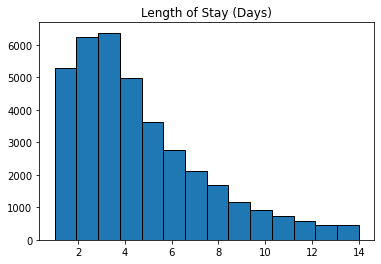

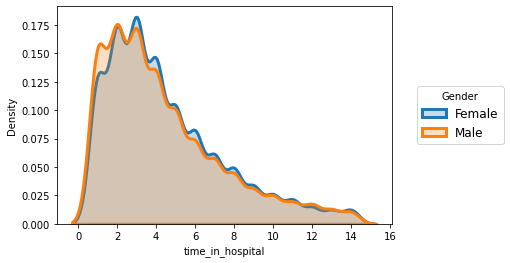

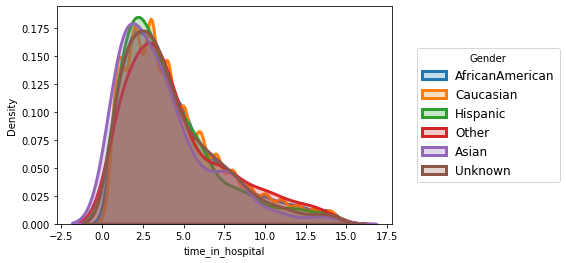

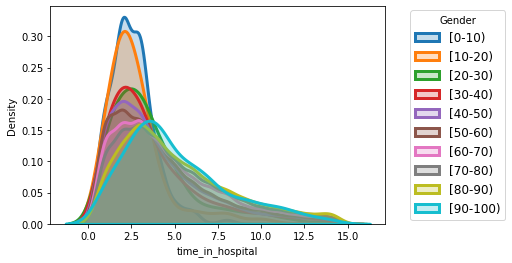

In [ ]:
warnings.filterwarnings("ignore")

# Exploratory Analysis
fig, ax = plt.subplots()
ax.hist(data['time_in_hospital'], bins=14, edgecolor="black")
ax.set_title('Length of Stay (Days)')
plt.show()

# Density Plots
for gender in data['gender'].unique():
  if gender == 'Unknown/Invalid':
    continue
  subset = data[data['gender']==gender]
  
  sns.distplot(subset['time_in_hospital'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = gender)

plt.legend(prop={'size': 12}, title = 'Gender', loc=6, borderaxespad=30.)
plt.show()

for race in data['race'].unique():
  if race == '?':
    continue
  subset = data[data['race']==race]
  
  sns.distplot(subset['time_in_hospital'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = race)

plt.legend(prop={'size': 12}, title = 'Gender', loc=6, borderaxespad=30.)
plt.show()

for age in ['[0-10)','[10-20)', '[20-30)','[30-40)','[40-50)','[50-60)','[60-70)','[70-80)','[80-90)','[90-100)']:
  subset = data[data['age']==age]
  
  sns.distplot(subset['time_in_hospital'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = age)

plt.legend(prop={'size': 12}, title = 'Gender', loc=6, borderaxespad=30.)
plt.show()


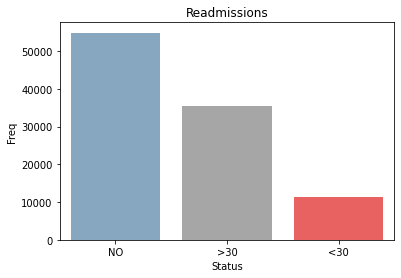

In [ ]:
pal = ['steelblue','grey','red']
sns.countplot(x='readmitted', data=data, palette=pal, alpha=0.7)
plt.title('Readmissions')
plt.ylabel('Freq')
plt.xlabel('Status')
plt.show()

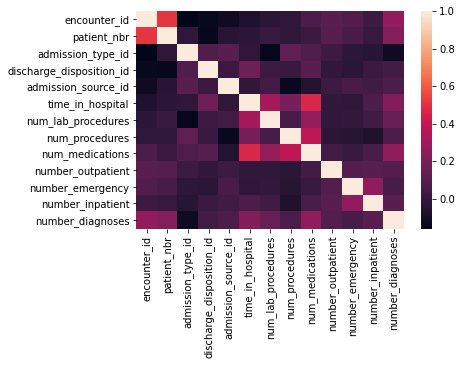

In [ ]:
# Correlation matrix
correlation_mat = data.corr()
sns.heatmap(correlation_mat)
plt.show()
# Correlation matrix only showing the ones with type int
# should we change to #'s ? 

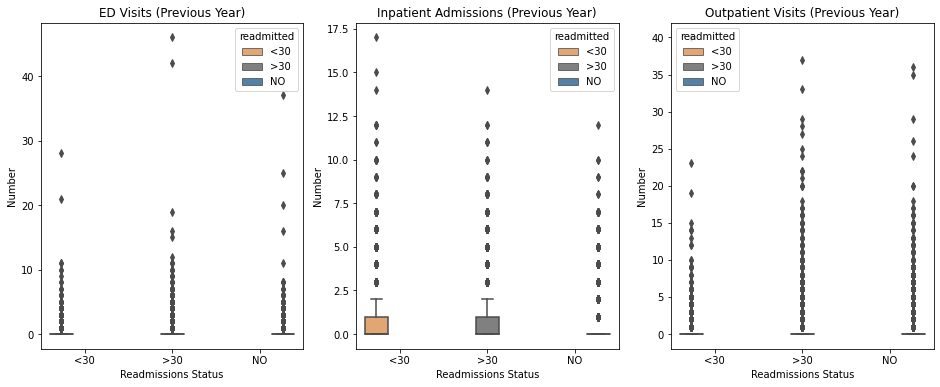

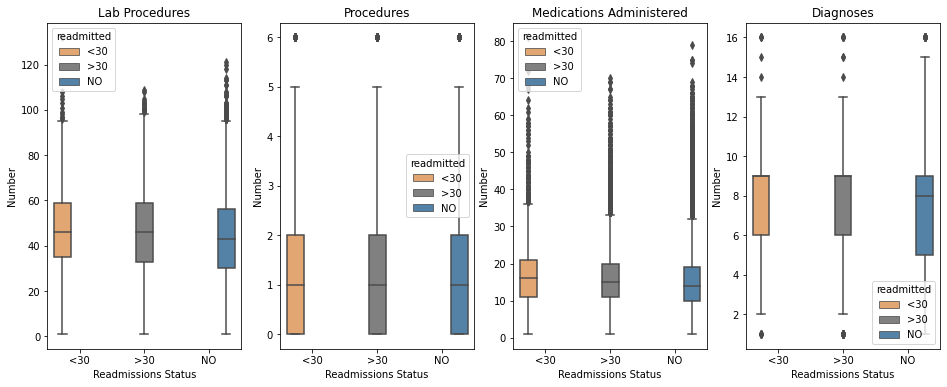

In [ ]:
# Continuous Variables

# box plots of distributions 

pal = ['sandybrown','grey','steelblue']

fig, ax  = plt.subplots(1,3, figsize=(16,6))
sns.boxplot(x=data['readmitted'], y=data['number_emergency'], hue=data['readmitted'], data=data, ax=ax[0], palette=pal)
sns.boxplot(x=data['readmitted'], y=data['number_inpatient'], hue=data['readmitted'], data=data, ax=ax[1], palette=pal)
sns.boxplot(x=data['readmitted'], y=data['number_outpatient'], hue=data['readmitted'], data=data, ax=ax[2], palette=pal)
# ax[0].legend(loc=9)
ax[0].set_title('ED Visits (Previous Year)')
ax[0].set_xlabel('Readmissions Status')
ax[0].set_ylabel('Number')
ax[1].set_title('Inpatient Admissions (Previous Year)')
ax[1].set_xlabel('Readmissions Status')
ax[1].set_ylabel('Number')
ax[2].set_title('Outpatient Visits (Previous Year)')
ax[2].set_xlabel('Readmissions Status')
ax[2].set_ylabel('Number')
plt.show()

fig, ax  = plt.subplots(1,4, figsize=(16,6))
sns.boxplot(x=data['readmitted'], y=data['num_lab_procedures'], hue=data['readmitted'], data=data, ax=ax[0], palette=pal)
sns.boxplot(x=data['readmitted'], y=data['num_procedures'], hue=data['readmitted'], data=data, ax=ax[1], palette=pal)
sns.boxplot(x=data['readmitted'], y=data['num_medications'], hue=data['readmitted'], data=data, ax=ax[2], palette=pal)
sns.boxplot(x=data['readmitted'], y=data['number_diagnoses'], hue=data['readmitted'], data=data, ax=ax[3], palette=pal)
# ax[0].legend(loc=9)
ax[0].set_title('Lab Procedures')
ax[0].set_xlabel('Readmissions Status')
ax[0].set_ylabel('Number')
ax[1].set_title('Procedures')
ax[1].set_xlabel('Readmissions Status')
ax[1].set_ylabel('Number')
ax[2].set_title('Medications Administered')
ax[2].set_xlabel('Readmissions Status')
ax[2].set_ylabel('Number')
ax[3].set_title('Diagnoses')
ax[3].set_xlabel('Readmissions Status')
ax[3].set_ylabel('Number')
plt.show()


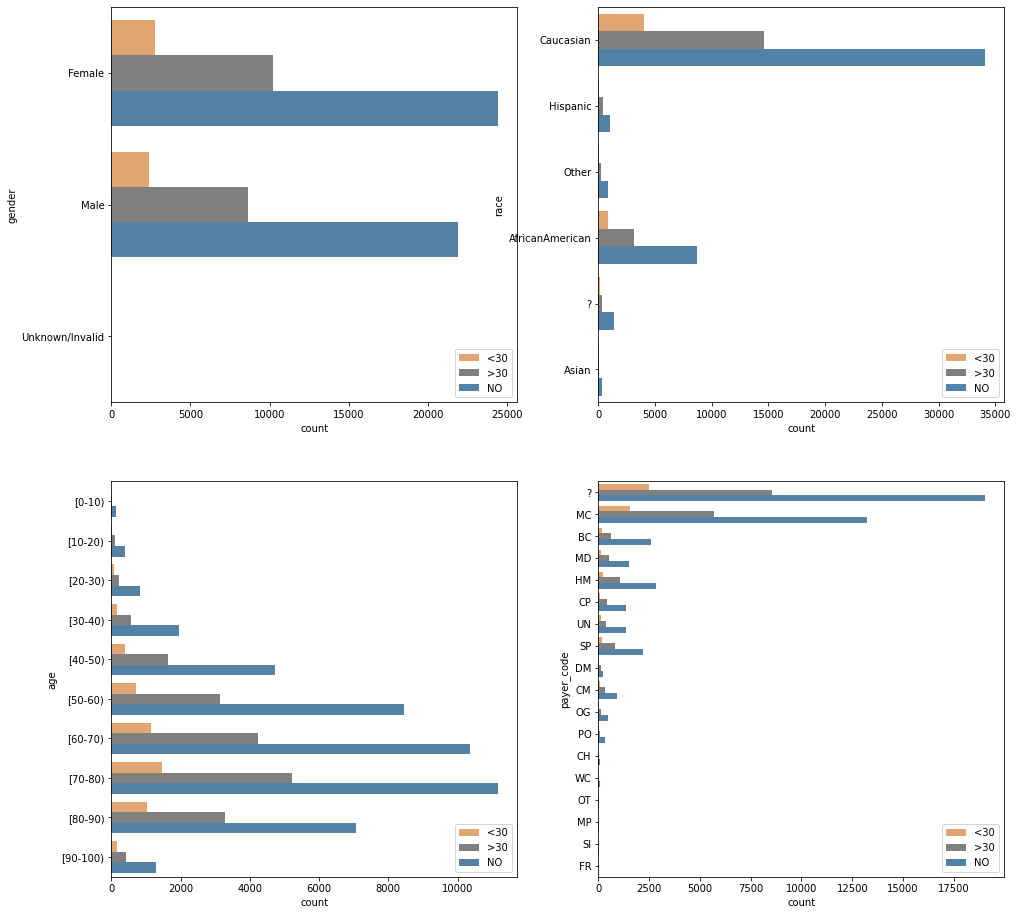

In [ ]:
# Categorical Variables

pal = ['sandybrown','grey','steelblue']
fig, ax  = plt.subplots(2,2, figsize=(16,16))
sns.countplot(data=data, y="gender", hue="readmitted", ax=ax[0,0], palette=pal)
ax[0,0].legend(loc=4)
sns.countplot(data=data, y="race", hue="readmitted", ax=ax[0,1], palette=pal)
ax[0,1].legend(loc=4)
sns.countplot(data=data, y="age", hue="readmitted", ax=ax[1,0], palette=pal, order=['[0-10)','[10-20)', '[20-30)',
       '[30-40)','[40-50)','[50-60)','[60-70)','[70-80)','[80-90)','[90-100)'])
ax[1,0].legend(loc=4)
sns.countplot(data=data, y="payer_code", hue="readmitted", ax=ax[1,1], palette=pal)
ax[1,1].legend(loc=4)
plt.show()


In [ ]:
# Chi-square tests for significant associations

cols = data.columns[data.dtypes=='object']

for col in cols:
  if col=='readmitted':
    continue
  crosstab = pd.crosstab(data[col], data['readmit_yn'])
  pval = chi2_contingency(crosstab)[1]
  if pval < 0.05/len(cols):
    print(crosstab.apply(lambda r: r/r.sum(), axis=1))
    print('p-val: ',"{0:.6f}".format(pval),'\n')


readmit_yn              0         1
race                               
?                0.942523  0.057477
AfricanAmerican  0.933748  0.066252
Asian            0.923541  0.076459
Caucasian        0.923712  0.076288
Hispanic         0.936255  0.063745
Other            0.941023  0.058977
p-val:  0.000027 

readmit_yn         0         1
age                           
[0-10)      0.980263  0.019737
[10-20)     0.964015  0.035985
[20-30)     0.934470  0.065530
[30-40)     0.941221  0.058779
[40-50)     0.942836  0.057164
[50-60)     0.941711  0.058289
[60-70)     0.926345  0.073655
[70-80)     0.917315  0.082685
[80-90)     0.909826  0.090174
[90-100)    0.919851  0.080149
p-val:  0.000000 

readmit_yn         0         1
weight                        
>200        1.000000  0.000000
?           0.927835  0.072165
[0-25)      0.825000  0.175000
[100-125)   0.898396  0.101604
[125-150)   0.914729  0.085271
[150-175)   0.911765  0.088235
[175-200)   0.900000  0.100000
[25-50)     0.917647  0

In [ ]:
# T-tests for continuous variables
cols = data.select_dtypes(include=['int']).columns

with np.errstate(divide='ignore'):
  res = []
  for col in cols:
    if col=='readmit_yn':
      continue
    mean_readmitted = data[data['readmit_yn']==1][col].mean()
    mean_not_readmitted = data[data['readmit_yn']==0][col].mean()
    try:
      tt_res = ttest_ind(data[data['readmit_yn']==1][col],
                        data[data['readmit_yn']==0][col],
                        nan_policy='omit')
      pval = tt_res[1]
      if pval < 0.05/len(cols):
        new_res = {'feature':col,
                  'Mean, Readmitted':mean_readmitted, 
                  'Mean, Not Readmitted': mean_not_readmitted,
                  'p-val':"{0:.8f}".format(pval)}
        res.append(new_res)

    except:
      continue

# Display features
pd.DataFrame(res).sort_values('p-val')

,feature,"Mean, Readmitted","Mean, Not Readmitted",p-val
0,encounter_id,1.531592e+08,1.638227e+08,0.00000000
1,patient_nbr,5.816671e+07,5.474122e+07,0.00000000
2,time_in_hospital,4.836814e+00,4.254600e+00,0.00000000
3,num_lab_procedures,4.565120e+01,4.282020e+01,0.00000000
4,num_medications,1.682077e+01,1.565459e+01,0.00000000
6,number_emergency,2.177108e-01,1.151577e-01,0.00000000
7,number_inpatient,7.652746e-01,2.989413e-01,0.00000000
8,number_diagnoses,7.626257e+00,7.248579e+00,0.00000000
5,number_outpatient,3.776102e-01,3.023580e-01,0.00000446


# Splitting Data into training (60%), validation (10%), and testing (30%)



In [ ]:
final = data.copy()
final = final.sample(frac=1, random_state=123).reset_index(drop=True)

# Split Train, Test, and Validation Sets
test_size = int(final.shape[0] * 0.3)
train_size = int(final.shape[0] * 0.6)

train_ids = final.head(train_size).index.unique()
test_ids = final.tail(test_size).index.unique()
valid_ids = final[(~final.index.isin(test_ids)) & (~final.index.isin(train_ids))].index.unique()

train = final.loc[train_ids]
valid = final.loc[valid_ids]
test = final.loc[test_ids]

print('Num train in test:',sum(train.index.isin(test_ids)))
print('Num test in train:',sum(test.index.isin(train_ids)))
print('Num valid in train:',sum(valid.index.isin(train_ids)))
print('Num valid in test:',sum(valid.index.isin(test_ids)))

train.shape, valid.shape, test.shape

Num train in test: 0
Num test in train: 0
Num valid in train: 0
Num valid in test: 0


((22418, 52), (3737, 52), (11209, 52))

In [ ]:
[(train.columns.get_loc(col),col) for col in train.columns]

[(0, 'encounter_id'),
 (1, 'patient_nbr'),
 (2, 'race'),
 (3, 'gender'),
 (4, 'age'),
 (5, 'weight'),
 (6, 'time_in_hospital'),
 (7, 'payer_code'),
 (8, 'num_lab_procedures'),
 (9, 'num_procedures'),
 (10, 'num_medications'),
 (11, 'number_outpatient'),
 (12, 'number_emergency'),
 (13, 'number_inpatient'),
 (14, 'number_diagnoses'),
 (15, 'max_glu_serum'),
 (16, 'A1Cresult'),
 (17, 'metformin'),
 (18, 'repaglinide'),
 (19, 'nateglinide'),
 (20, 'chlorpropamide'),
 (21, 'glimepiride'),
 (22, 'acetohexamide'),
 (23, 'glipizide'),
 (24, 'glyburide'),
 (25, 'tolbutamide'),
 (26, 'pioglitazone'),
 (27, 'rosiglitazone'),
 (28, 'acarbose'),
 (29, 'miglitol'),
 (30, 'troglitazone'),
 (31, 'tolazamide'),
 (32, 'examide'),
 (33, 'citoglipton'),
 (34, 'insulin'),
 (35, 'glyburide-metformin'),
 (36, 'glipizide-metformin'),
 (37, 'glimepiride-pioglitazone'),
 (38, 'metformin-rosiglitazone'),
 (39, 'metformin-pioglitazone'),
 (40, 'change'),
 (41, 'diabetesMed'),
 (42, 'readmitted'),
 (43, 'admissio

**Analysis**

Features we will use: \\
       'race', 'gender', 'age', 'weight',
       'time_in_hospital', 'payer_code', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed',
       'admission_type', 'discharge_disposition_category', 'ccs_1_desc', 
       'weight_yn', 'medical_specialty_category'

In [ ]:
# Train: Separate features and label
X_train = train[['race','gender','age','weight_yn','weight','ccs_1_desc','number_outpatient','number_emergency','number_inpatient','number_diagnoses',
                 'medical_specialty_category','max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 
                 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 
                 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 
                 'metformin-pioglitazone', 'change', 'diabetesMed', 'admission_type', 'discharge_disposition_category']]
y_train = train['readmit_yn']
# y_train = train['time_in_hospital']

# Validation: Separate features and label
X_valid = valid[['race','gender','age','weight_yn','weight','ccs_1_desc','number_outpatient','number_emergency','number_inpatient','number_diagnoses',
                 'medical_specialty_category','max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 
                 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 
                 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 
                 'metformin-pioglitazone', 'change', 'diabetesMed', 'admission_type', 'discharge_disposition_category']]
y_valid = valid['readmit_yn']
# y_valid = valid['time_in_hospital']

# Test: Separate features and label
X_test = test[['race','gender','age','weight_yn','weight','ccs_1_desc','number_outpatient','number_emergency','number_inpatient','number_diagnoses',
                 'medical_specialty_category','max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 
                 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 
                 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 
                 'metformin-pioglitazone', 'change', 'diabetesMed', 'admission_type', 'discharge_disposition_category']]
y_test = test['readmit_yn']
# y_test = test['time_in_hospital']


## Imputation

In [ ]:
warnings.filterwarnings("ignore")
# Weight is provided as a categorical variable, so we determine the mode across age groups
mode_weight_0_10 = data[data.age == '[0-10)'].weight.mode()
mode_weight_10_20 = data[data.age == '[10-20)'].weight.mode()
mode_weight_other = data[~data.age.isin(['[0-10)','[10-20)'])].weight.mode()
 
X_train['weight'] = np.where(X_train.weight.isna() & X_train.age == '[0-10)', mode_weight_0_10,
                             np.where(X_train.weight.isna() & X_train.age == '[10-20)', mode_weight_10_20,
                                      np.where(X_train.weight.isna() & ~X_train.age.isin(['[0-10)','[10-20)']), mode_weight_other,X_train.weight)))

X_valid['weight'] = np.where(X_valid.weight.isna() & X_valid.age == '[0-10)', mode_weight_0_10,
                             np.where(X_valid.weight.isna() & X_valid.age == '[10-20)', mode_weight_10_20,
                                      np.where(X_valid.weight.isna() & ~X_valid.age.isin(['[0-10)','[10-20)']), mode_weight_other,X_valid.weight)))

X_test['weight'] = np.where(X_test.weight.isna() & X_test.age == '[0-10)', mode_weight_0_10,
                             np.where(X_test.weight.isna() & X_test.age == '[10-20)', mode_weight_10_20,
                                      np.where(X_test.weight.isna() & ~X_test.age.isin(['[0-10)','[10-20)']), mode_weight_other,X_test.weight)))

## One-hot Encoding

In [ ]:
# One-hot encoding
X_train = pd.get_dummies(X_train, columns=['race','gender','age','ccs_1_desc','weight','medical_specialty_category','max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 
                 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 
                 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 
                 'metformin-pioglitazone', 'change', 'diabetesMed', 'admission_type', 'discharge_disposition_category'])
X_valid = pd.get_dummies(X_valid, columns=['race','gender','age','ccs_1_desc','weight','medical_specialty_category','max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 
                 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 
                 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 
                 'metformin-pioglitazone', 'change', 'diabetesMed', 'admission_type', 'discharge_disposition_category'])
X_test = pd.get_dummies(X_test, columns=['race','gender','age','ccs_1_desc','weight','medical_specialty_category','max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 
                 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 
                 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 
                 'metformin-pioglitazone', 'change', 'diabetesMed', 'admission_type', 'discharge_disposition_category'])

X_train, X_valid = X_train.align(X_valid, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left', axis=1)

# print(X_train.shape)
# print(X_valid.shape)
# print(X_test.shape)

# Fill Missing Diagnoses with 0's
X_valid.iloc[:,5:] = X_valid.iloc[:,5:].fillna(0)
X_test.iloc[:,5:] = X_test.iloc[:,5:].fillna(0)

## Standardization
We standardized features for regularized regression.

In [ ]:
# Scale data
scaler = StandardScaler()
X_train_std = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

# Scale validation and test sets
X_valid_std = pd.DataFrame(scaler.transform(X_valid), columns=X_valid.columns)
X_test_std = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Modeling: Length of Stay

In [ ]:
# Modeling 
# Steps followed: Choose an algorithm, overfit, reduce overfit with regularization

# *** For length of stay (days) in the hospital, we will use linear regression ***
# *** Linear model with no regularization ***
regr = linear_model.LinearRegression()
#y_train = y_train.values.ravel()
# Train the model using the training sets
regr.fit(X_train_std, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test_std)
print(y_test)
print(y_pred)

from sklearn.metrics import r2_score
print(r2_score(y_train, y_pred_train))
print(r2_score(y_test, y_pred))

# The coefficients
# print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

scores_length_no_reg = cross_val_score(regr, X_train_std, y_train, cv=5, scoring='r2') 
regr.fit(X_train_std, y_train)
#The mean score and the standard deviation are hence given by:
print("%0.2f (No regularization) accuracy with a standard deviation of %0.2f" % (scores_length_no_reg.mean(), scores_length_no_reg.std()))

# *** linear model with L1 regularization ***

# Alpha = 0.1
regr_l1_1 = linear_model.Lasso(alpha=0.1)
scores_length_l1_1_reg = cross_val_score(regr_l1_1, X_train_std, y_train, cv=5, scoring='r2') 
regr_l1_1.fit(X_train_std, y_train)
#The mean score and the standard deviation are hence given by:
print("%0.2f (with L1 alpha = 0.1) accuracy with a standard deviation of %0.2f" % (scores_length_l1_1_reg.mean(), scores_length_l1_1_reg.std()))

# Alpha = 30
regr_l1_30 = linear_model.Lasso(alpha=30)
scores_length_l1_30_reg = cross_val_score(regr_l1_30, X_train_std, y_train, cv=5, scoring='r2') 
regr_l1_30.fit(X_train_std, y_train)
#The mean score and the standard deviation are hence given by:
print("%0.2f (with L1 alpha = 30) accuracy with a standard deviation of %0.2f" % (scores_length_l1_30_reg.mean(), scores_length_l1_30_reg.std()))

# Alpha = 100
regr_l1_100 = linear_model.Lasso(alpha=100)
scores_length_l1_100_reg = cross_val_score(regr_l1_100, X_train_std, y_train, cv=5, scoring='r2') 
#regr_l1_30.fit(X_train_std, y_train)
#The mean score and the standard deviation are hence given by:
print("%0.2f (with L1 alpha = 100) accuracy with a standard deviation of %0.2f" % (scores_length_l1_100_reg.mean(), scores_length_l1_100_reg.std()))

# *** linear model with L2 regularization ***

# Alpha = 0.1
regr_l2_1 = linear_model.Ridge(alpha=0.1)
scores_length_l2_1_reg = cross_val_score(regr_l2_1, X_train_std, y_train, cv=5, scoring='r2') 
regr_l2_1.fit(X_train_std, y_train)
#The mean score and the standard deviation are hence given by:
print("%0.2f (with L2 alpha = 0.1) accuracy with a standard deviation of %0.2f" % (scores_length_l2_1_reg.mean(), scores_length_l2_1_reg.std()))

# Alpha = 30
regr_l2_30 = linear_model.Ridge(alpha=30)
scores_length_l2_30_reg = cross_val_score(regr_l2_30, X_train_std, y_train, cv=5, scoring='r2') 
regr_l2_30.fit(X_train_std, y_train)
#The mean score and the standard deviation are hence given by:
print("%0.2f (with L2 alpha = 30) accuracy with a standard deviation of %0.2f" % (scores_length_l2_30_reg.mean(), scores_length_l2_30_reg.std()))

# Alpha = 100
regr_l2_100 = linear_model.Ridge(alpha=100)
scores_length_l2_100_reg = cross_val_score(regr_l2_100, X_train_std, y_train, cv=5, scoring='r2') 
regr_l2_100.fit(X_train_std, y_train)
#print(scores_length_l2_100_reg)
#The mean score and the standard deviation are hence given by:
print("%0.2f (with L2 alpha = 100) accuracy with a standard deviation of %0.2f" % (scores_length_l2_100_reg.mean(), scores_length_l2_100_reg.std()))
#print(patient)


In [ ]:
# Modeling with Poisson Regressor

import sklearn
from sklearn.linear_model import PoissonRegressor
regr = PoissonRegressor(alpha=1.0, fit_intercept=True, max_iter=100, tol=0.0001, warm_start=False, verbose=0)
regr.fit(X_train_std, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test_std)

from sklearn.metrics import r2_score
print(r2_score(y_test, y_pred))

# The coefficients
# print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

scores_length_no_reg = cross_val_score(regr, X_train_std, y_train, cv=5, scoring='r2') 
regr.fit(X_train_std, y_train)
#The mean score and the standard deviation are hence given by:
print("%0.2f (alpha = 1.0) accuracy with a standard deviation of %0.2f" % (scores_length_no_reg.mean(), scores_length_no_reg.std()))

# Alpha = 0.1
regr_l1_1 = linear_model.PoissonRegressor(alpha=0.01)
scores_length_l1_1_reg = cross_val_score(regr_l1_1, X_train_std, y_train, cv=5, scoring='r2') 
regr_l1_1.fit(X_train_std, y_train)
#The mean score and the standard deviation are hence given by:
print("%0.2f (alpha = 0.01) accuracy with a standard deviation of %0.2f" % (scores_length_l1_1_reg.mean(), scores_length_l1_1_reg.std()))

# Alpha = 30
regr_l1_30 = linear_model.PoissonRegressor(alpha=30)
scores_length_l1_30_reg = cross_val_score(regr_l1_30, X_train_std, y_train, cv=5, scoring='r2') 
regr_l1_30.fit(X_train_std, y_train)
#The mean score and the standard deviation are hence given by:
print("%0.2f (alpha = 30) accuracy with a standard deviation of %0.2f" % (scores_length_l1_30_reg.mean(), scores_length_l1_30_reg.std()))

# Alpha = 100
regr_l1_100 = linear_model.PoissonRegressor(alpha=0.001)
scores_length_l1_100_reg = cross_val_score(regr_l1_100, X_train_std, y_train, cv=5, scoring='r2') 
#regr_l1_30.fit(X_train_std, y_train)
#The mean score and the standard deviation are hence given by:
print("%0.2f (alpha = 100) accuracy with a standard deviation of %0.2f" % (scores_length_l1_100_reg.mean(), scores_length_l1_100_reg.std()))

# Modeling: 30-Day Readmissions

In [ ]:
# For 30-day readmission, we will use logistic regression, gradient boosting, and random forest classifiers.
# Process

# Standardize features
# Compute mean and stdev on training set for standardization

# Logistic regression

# Covalidation score

# Gradient boosting

## Logistic Regression with L1 Regularization

In [ ]:
# Set parameters
n_folds = 5
C_values = [0.001,0.01,1]

# Fit model
lrcv_l1_clf = LogisticRegressionCV(Cs=C_values, cv=n_folds, penalty='l1', 
                           refit=False, scoring='roc_auc', max_iter=50,
                           solver='liblinear', random_state=42,
                           fit_intercept=False, n_jobs=-1)

lrcv_l1_clf.fit(X_train_std, y_train.values.ravel())

print('CV Max AUC:', lrcv_l1_clf.scores_[1].max())

CV Max AUC: 0.6893570158422244


In [ ]:
# Coefficients

feature_list = list(X_train_std.columns)
coefficients = lrcv_l1_clf.coef_[0]

feature_coefficients = list(zip(feature_list, coefficients))
coef_list = [list(x) for x in feature_coefficients]
coef_df = pd.DataFrame(coef_list, columns=["Variable", "Coefficient"])
coef_df['Abs Coef'] = abs(coef_df['Coefficient'])
coef_df['OR'] = np.exp(coef_df['Coefficient'])


# Display Features with Odds Ratios
coef_df[coef_df['Abs Coef']>0.1].sort_values('Abs Coef', ascending=False)[['Variable','Coefficient','OR']]

,Variable,Coefficient,OR
82,ccs_1_desc_ENCEPHALITIS (EXCEPT THAT CAUSED BY...,38.158190,3.731568e+16
288,admission_type_Trauma Center,37.858557,2.765428e+16
225,nateglinide_Down,13.273658,5.816696e+05
258,miglitol_Down,12.951344,4.214028e+05
265,tolazamide_Up,12.835025,3.751291e+05
107,ccs_1_desc_INFLAMMATION; INFECTION OF EYE (EXC...,12.480893,2.632589e+05
57,ccs_1_desc_CANCER OF OTHER MALE GENITAL ORGANS,12.330993,2.266116e+05
50,ccs_1_desc_CANCER OF CERVIX,12.199673,1.987241e+05
3,number_inpatient,0.174549,1.190709e+00
257,acarbose_Up,0.135377,1.144968e+00


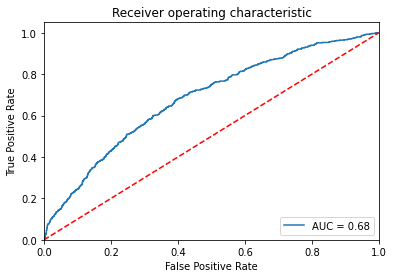

In [ ]:
valid_preds = pd.Series(lrcv_clf.predict_proba(X_valid_std)[:,1])
valid_preds = valid_preds.values
valid_preds = np.array([valid_preds,valid_preds]).T
roc_plot(y_valid,valid_preds)

## Logistic Regression with L2 Regularization

In [ ]:
# Set parameters
n_folds = 5
C_values = [0.001,0.01,1]

# Fit model
lrcv_l2_clf = LogisticRegressionCV(Cs=C_values, cv=n_folds, penalty='l2', 
                           refit=False, scoring='roc_auc', max_iter=50,
                           solver='liblinear', random_state=42,
                           fit_intercept=False, n_jobs=-1)

lrcv_l2_clf.fit(X_train_std, y_train.values.ravel())

print('CV Max AUC:', lrcv_l2_clf.scores_[1].max())

CV Max AUC: 0.67800544239681


In [ ]:
# Coefficients

feature_list = list(X_train_std.columns)
coefficients = lrcv_l2_clf.coef_[0]

feature_coefficients = list(zip(feature_list, coefficients))
coef_list = [list(x) for x in feature_coefficients]
coef_df = pd.DataFrame(coef_list, columns=["Variable", "Coefficient"])
coef_df['Abs Coef'] = abs(coef_df['Coefficient'])
coef_df['OR'] = np.exp(coef_df['Coefficient'])


# Display Features with Odds Ratios
coef_df.sort_values('Abs Coef', ascending=False)[['Variable','Coefficient','OR']][0:25]

,Variable,Coefficient,OR
257,acarbose_Up,8.212246,3685.812147
102,ccs_1_desc_HODGKIN`S DISEASE,5.805303,332.055925
106,ccs_1_desc_INDUCED ABORTION,5.727541,307.212923
96,ccs_1_desc_GLAUCOMA,5.726287,306.827845
119,ccs_1_desc_MELANOMAS OF SKIN,5.726064,306.759533
138,ccs_1_desc_OTHER CNS INFECTION AND POLIOMYELITIS,5.721934,305.495331
258,miglitol_Down,4.736126,113.991796
50,ccs_1_desc_CANCER OF CERVIX,4.734476,113.803822
57,ccs_1_desc_CANCER OF OTHER MALE GENITAL ORGANS,4.734136,113.765068
265,tolazamide_Up,4.733995,113.749123


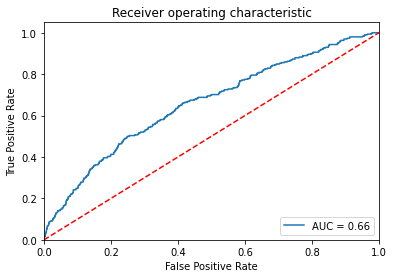

In [ ]:
valid_preds = pd.Series(lrcv_l2_clf.predict_proba(X_valid_std)[:,1])
valid_preds = valid_preds.values
valid_preds = np.array([valid_preds,valid_preds]).T
roc_plot(y_valid,valid_preds)

## Random Forest

In [ ]:
# Random Forest Classifier

rfc=RandomForestClassifier(random_state=123)

param_grid = { 
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,6,8,10,12],
    'criterion' :['entropy']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train.values.ravel())

CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 4,
 'max_features': 'auto',
 'n_estimators': 100}

In [ ]:
# Display Feature Importances
importances = CV_rfc.best_estimator_.feature_importances_

indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(X_train.shape[1]):
  print("%d. feature %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature discharge_disposition_category_Discharged to home (0.158618)
2. feature number_inpatient (0.143816)
3. feature discharge_disposition_category_Discharged to facility (0.070020)
4. feature number_diagnoses (0.067456)
5. feature number_emergency (0.045006)
6. feature number_outpatient (0.028377)
7. feature ccs_1_desc_CORONARY ATHEROSCLEROSIS AND OTHER HEART DISEASE (0.024463)
8. feature ccs_1_desc_ACUTE CEREBROVASCULAR DISEASE (0.021263)
9. feature insulin_No (0.019675)
10. feature medical_specialty_category_Emergency/Trauma (0.017739)
11. feature insulin_Down (0.015986)
12. feature age_[70-80) (0.013317)
13. feature ccs_1_desc_OTHER CIRCULATORY DISEASE (0.013196)
14. feature medical_specialty_category_Unknown/Other (0.013115)
15. feature age_[80-90) (0.012028)
16. feature ccs_1_desc_OTHER AFTERCARE (0.009968)
17. feature age_[50-60) (0.009260)
18. feature discharge_disposition_category_Discharged to home health (0.008472)
19. feature age_[40-50) (0.008469)
20.

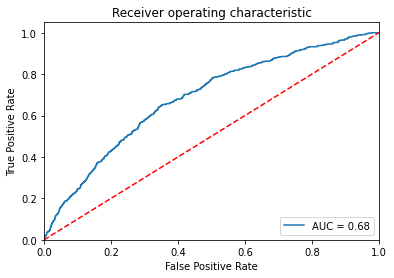

In [ ]:
valid_preds = pd.Series(CV_rfc.predict_proba(X_valid)[:,1])
valid_preds = valid_preds.values
valid_preds = np.array([valid_preds,valid_preds]).T
roc_plot(y_valid,valid_preds)


## Gradient Boosting Classifier

In [ ]:
# Gradient Boosting Classifier
gbc=GradientBoostingClassifier(random_state=123)

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,8,12,16],
    'learning_rate': [0.005,0.01,0.1,1]
}

CV_gbc = GridSearchCV(estimator=gbc, param_grid=param_grid, scoring='roc_auc', cv= 5)
CV_gbc.fit(X_train, y_train.values.ravel())

CV_gbc.best_params_

{'learning_rate': 0.005,
 'max_depth': 12,
 'max_features': 'sqrt',
 'n_estimators': 500}

In [ ]:
# Display Feature Importances
importances = CV_gbc.best_estimator_.feature_importances_

indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(X_train.shape[1]):
  print("%d. feature %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature number_inpatient (0.091625)
2. feature number_diagnoses (0.051619)
3. feature discharge_disposition_category_Discharged to facility (0.031834)
4. feature discharge_disposition_category_Discharged to home (0.025900)
5. feature number_emergency (0.024367)
6. feature number_outpatient (0.023968)
7. feature medical_specialty_category_Unknown/Other (0.017581)
8. feature gender_Female (0.016060)
9. feature gender_Male (0.015835)
10. feature age_[70-80) (0.015783)
11. feature admission_type_Emergency (0.014460)
12. feature medical_specialty_category_Internal/Family Medicine (0.013310)
13. feature race_Caucasian (0.013136)
14. feature age_[80-90) (0.012725)
15. feature insulin_No (0.012643)
16. feature insulin_Steady (0.012274)
17. feature admission_type_Urgent (0.012126)
18. feature race_AfricanAmerican (0.011464)
19. feature age_[60-70) (0.011214)
20. feature admission_type_Elective (0.011003)
21. feature admission_type_NA (0.010675)
22. feature change_No (0.01055

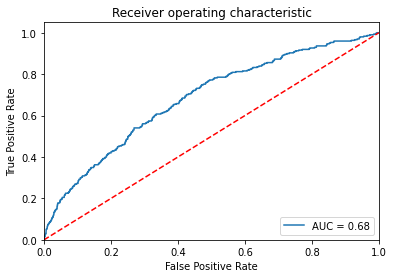

In [ ]:
valid_preds = pd.Series(CV_gbc.predict_proba(X_valid)[:,1])
valid_preds = valid_preds.values
valid_preds = np.array([valid_preds,valid_preds]).T
roc_plot(y_valid,valid_preds)


In [ ]:
# Analysis and Evaluation 

# Do cross validation in every algorithm

# Evaluation metrics 

# Feature importance

# Training/ Inference/ Time/ Cost

# Comparison to other models

# Least confident examples

# Bias/ Variance trade-off

NOTES:

It is okay to use existing libraries in your project implementation, as long as a) you are citing all sources and b) you are still showing a proficiency with some of the concepts learned in class (whether they be particular approaches, necessities of data processing, or evaluation techniques)

https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

https://whimsical.com/machine-learning-roadmap-2020-CA7f3ykvXpnJ9Az32vYXva
